In [1]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


In [2]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 10
batch_size = 32


In [3]:
train_path = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training'
valid_path = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Validation'
# train_path = '../large_files/fruits-360-small/Training'
# valid_path = '../large_files/fruits-360-small/Validation'


In [4]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')


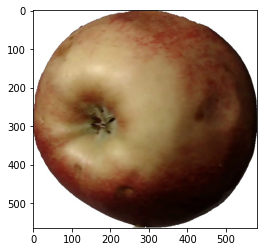

In [5]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()


In [6]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


2021-11-14 08:27:04.090997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 08:27:04.208889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 08:27:04.209583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 08:27:04.210681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [9]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



In [10]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


Found 3114 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
min: -119.605545 max: 151.061


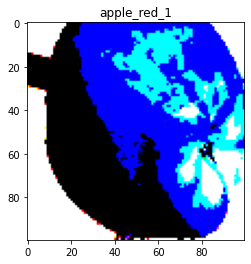

In [11]:

# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [12]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [13]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-14 08:27:09.845438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-14 08:27:11.658504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


194/194 [==============================] - 106s 513ms/step - loss: 3.3666 - accuracy: 0.7803 - val_loss: 0.6960 - val_accuracy: 0.9253
Epoch 2/10
194/194 [==============================] - 59s 305ms/step - loss: 0.8686 - accuracy: 0.9258 - val_loss: 0.4103 - val_accuracy: 0.9562
Epoch 3/10
194/194 [==============================] - 60s 309ms/step - loss: 0.4877 - accuracy: 0.9526 - val_loss: 0.3607 - val_accuracy: 0.9694
Epoch 4/10
194/194 [==============================] - 60s 308ms/step - loss: 0.4860 - accuracy: 0.9623 - val_loss: 0.3008 - val_accuracy: 0.9720
Epoch 5/10
194/194 [==============================] - 60s 312ms/step - loss: 0.3819 - accuracy: 0.9697 - val_loss: 0.1834 - val_accuracy: 0.9836
Epoch 6/10
194/194 [==============================] - 60s 310ms/step - loss: 0.2879 - accuracy: 0.9750 - val_loss: 0.2096 - val_accuracy: 0.9787
Epoch 7/10
194/194 [==============================] - 61s 314ms/step - loss: 0.2980 - accuracy: 0.9756 - val_loss: 0.1736 - val_accuracy: 0.

In [14]:


def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)



Generating confusion matrix 6231
Found 6231 images belonging to 24 classes.
50
[[308   0   0   0   2   0   3   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 318   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   2 315   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 304   0   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   0   1  10 274  21   0   0   0   1   0   0   0   0   0   0   0
    0   0   9   0   0   0]
 [  0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 468   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   1   8   0   0   0   0   0 295   1   6   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   1   

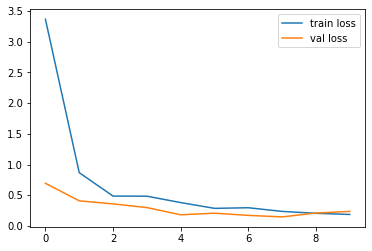

In [15]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


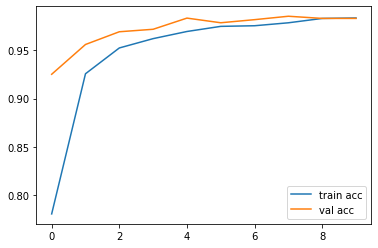

In [16]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [17]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  plt.rcParams["figure.figsize"] = (40,20)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion matrix, without normalization
[[308   0   0   0   2   0   3   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 318   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   2 315   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 304   0   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0]
 [  0   0   0   1  10 274  21   0   0   0   1   0   0   0   0   0   0   0
    0   0   9   0   0   0]
 [  0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 468   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   1   8   0   0   0   0   0 295   1   6   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   1   1   0   0   0   0   0   0 307   0   0  

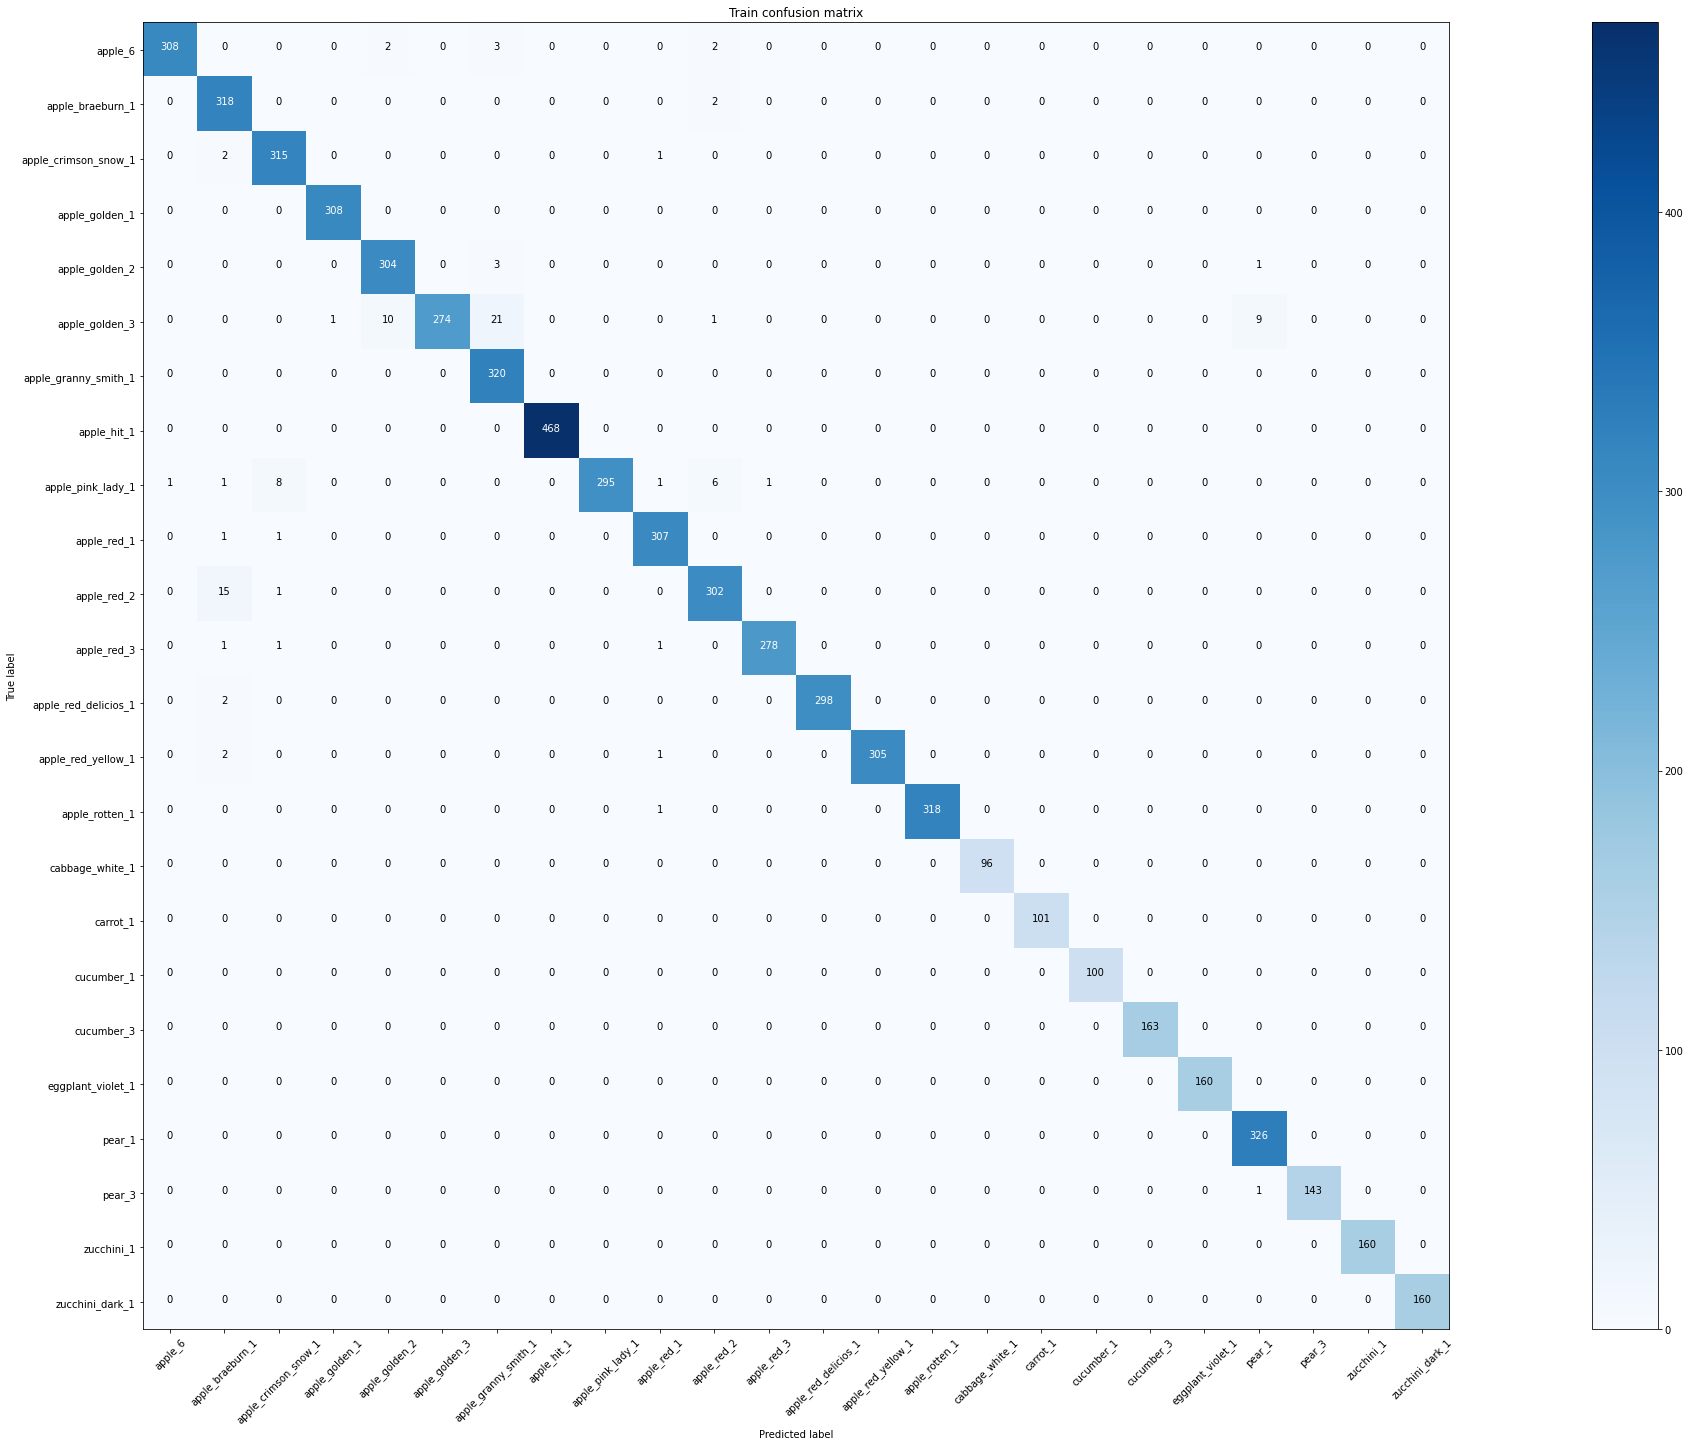

Confusion matrix, without normalization
[[156   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   3 156   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 153   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   2   4 136   9   0   0   0   1   0   0   0   0   0   0   0
    0   0   6   0   0   0]
 [  0   0   0   0   0   0 160   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 234   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   2   5   0   0   0   0   0 141   2   6   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 155   0   0  

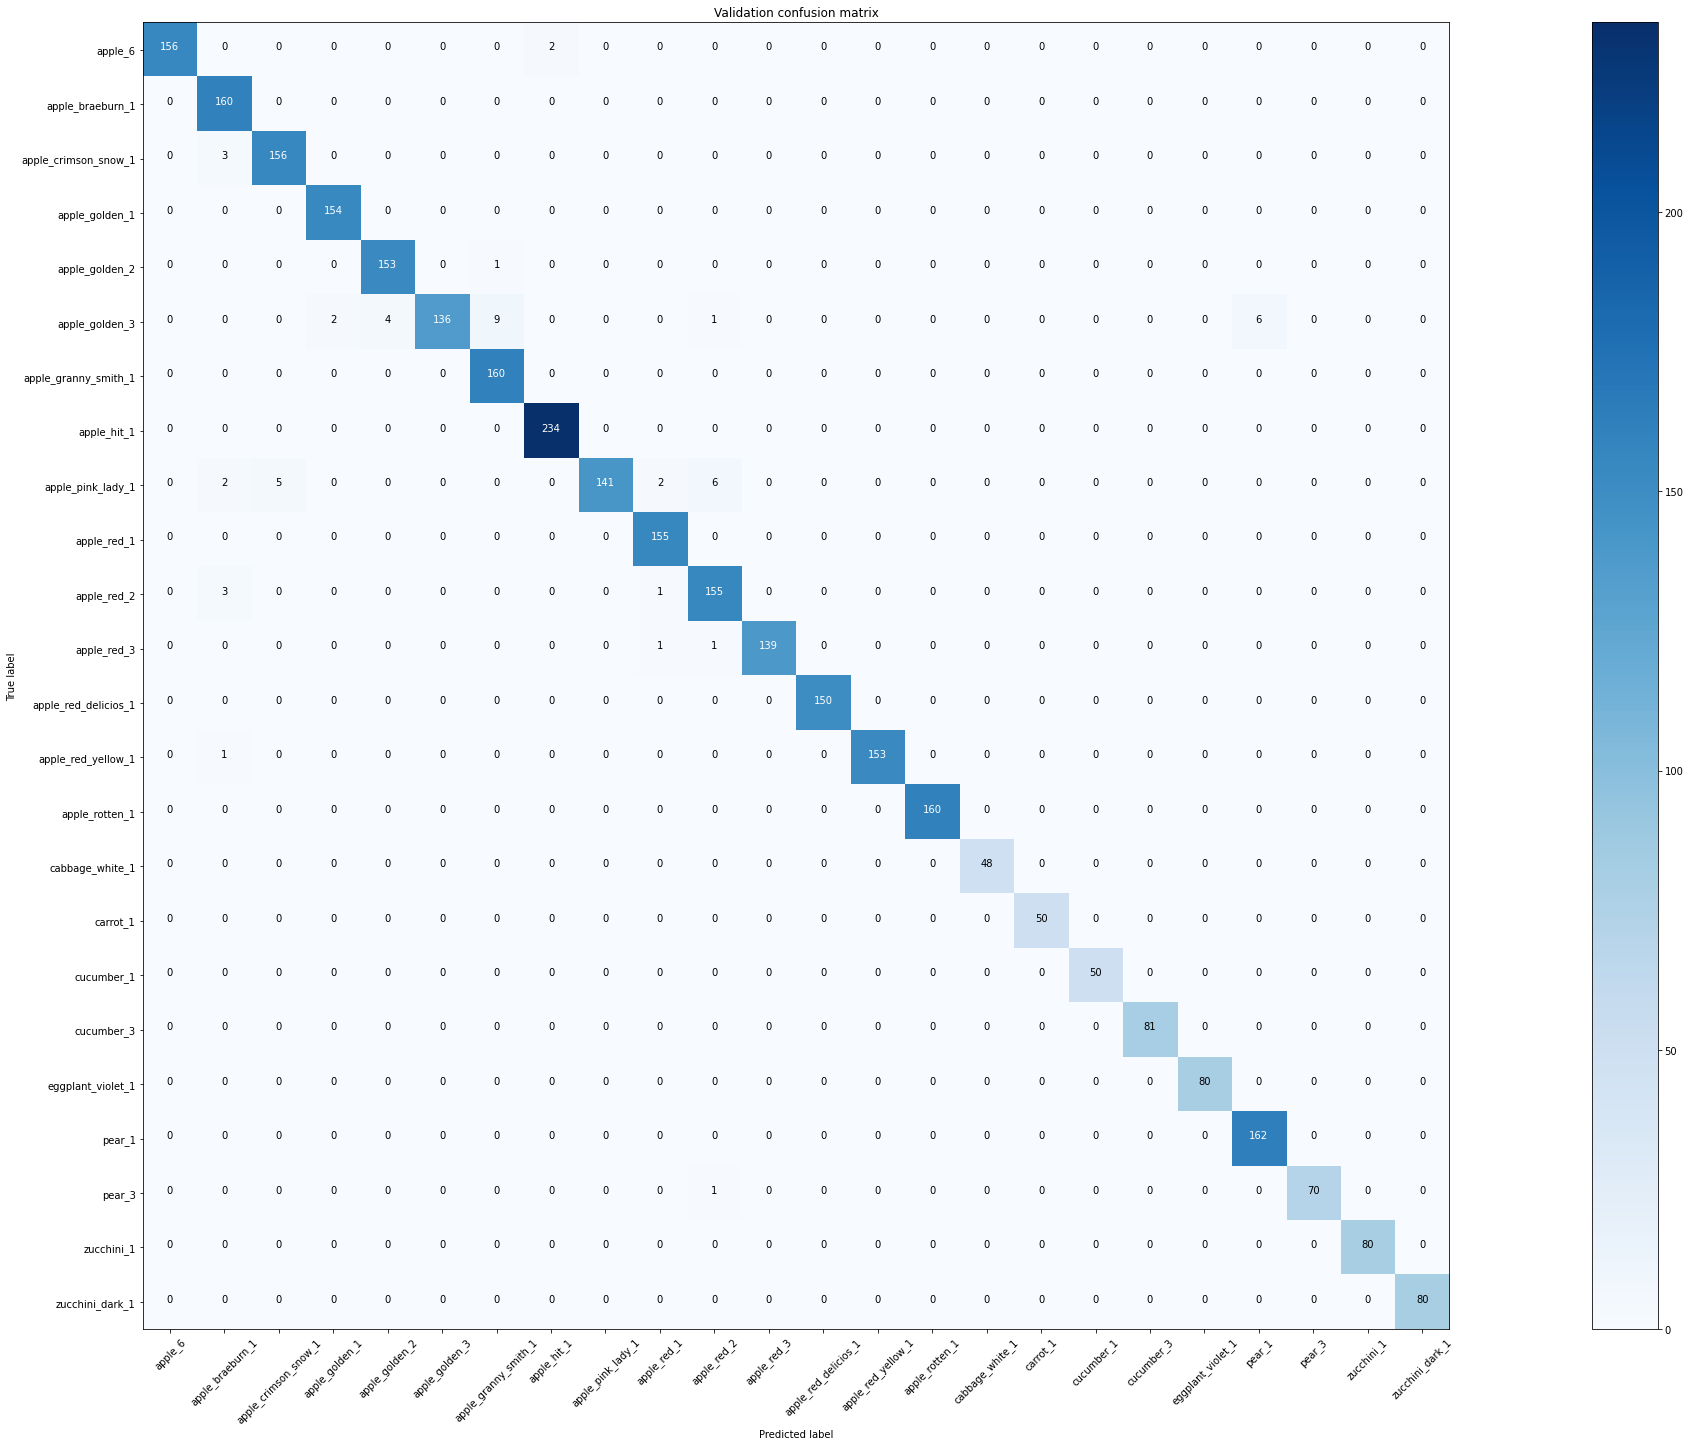

In [18]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')